In [ ]:
import pandas as pd
import os
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from nltk.stem import PorterStemmer
import re

from sklearn.model_selection import KFold, train_test_split
import numpy as np
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# change
BINANCE_DIR = "/content/drive/MyDrive/ML project data"
TWITTER_DIR = "/content/drive/MyDrive/ML project data"
REDDIT_DIR = "/content/drive/MyDrive/ML project data"

TWITTER_FILE = "twitter.csv"
REDDIT_FILE  = "reddit.csv"
BINANCE_FILE = "binance.csv"
# dont change
BINANCE_EXTENSION = "csv"

START_DATE = "2018-01-01"
END_DATE = "2021-10-31"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def concatenate_content_values(content_list):
	return content_list.str.cat(sep=" ")

# Dataset

### Binance

In [ ]:
# load binance data
df_binance = pd.read_csv(  os.path.join(BINANCE_DIR, BINANCE_FILE), lineterminator='\n' )

# convert time to date obj
df_binance['time'] = pd.to_datetime(df_binance['time'])

# change index to time
df_binance = df_binance.set_index('time')

# filter date range
df_binance = df_binance.loc[START_DATE:END_DATE]

In [ ]:
df_binance.head()

,price_mean,price_std,qty,label
time,,,,
2018-01-01,743.270688,10.753432,53909.25885,0.0
2018-01-02,845.150582,22.808532,113257.78355,1.0
2018-01-03,878.817822,28.050939,89041.45688,1.0
2018-01-04,949.332142,27.646329,102894.47384,1.0
2018-01-05,982.219534,25.293904,97374.01630,1.0


### Reddit

In [ ]:
# read reddit
df_reddit = pd.read_csv(  os.path.join(REDDIT_DIR, REDDIT_FILE), lineterminator='\n' )

# convert to date obj
df_reddit['date'] = pd.to_datetime(df_reddit['date'])

# Join all reddit posts for each day into one big string
df_reddit = df_reddit.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_reddit = df_reddit.loc[START_DATE:END_DATE]

In [ ]:
df_reddit.head()

,content,popularity
date,,
2018-01-01,how you do it? i cant change the onboard to pc...,2.104167
2018-01-02,"If you have nvidia experience, it'll prompt yo...",2.432655
2018-01-03,&gt; I'm getting pretty low hashrates on my ri...,1.912791
2018-01-04,http://brianford.tech/2017-10-10-etherMiningRi...,2.580911
2018-01-05,Currently I'm on wifi. I hear ethermine mines ...,2.102229


### Twitter

In [ ]:
# load twitter data
df_twitter = pd.read_csv( os.path.join(TWITTER_DIR, TWITTER_FILE), lineterminator="\n")

# convert to date obj
df_twitter['date'] = pd.to_datetime(df_twitter['date'])

# Join all tweets for each day into one big string
df_twitter = df_twitter.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_twitter = df_twitter.loc[START_DATE:END_DATE]

In [ ]:
df_twitter.head()

,content,popularity
date,,
2018-01-01,#Ethereum trade bot is attempting to sell. Cur...,0.049917
2018-01-02,#AIRDROP #EtherFlip #FLIP #LIVE @Ethereum_Flip...,0.012856
2018-01-03,#AIRDROP #EtherFlip #FLIP #LIVE @Ethereum_Flip...,0.068100
2018-01-04,Estonian enterprises will use the Ethereum blo...,0.025132
2018-01-05,Update: took 10 hours for my Ethereum payment ...,0.077095


In [ ]:
input_data = pd.concat([df_reddit,df_twitter]).groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

In [ ]:
daily_content = input_data.content

In [ ]:
daily_content

date
2018-01-01    how you do it? i cant change the onboard to pc...
2018-01-02    If you have nvidia experience, it'll prompt yo...
2018-01-03    &gt; I'm getting pretty low hashrates on my ri...
2018-01-04    http://brianford.tech/2017-10-10-etherMiningRi...
2018-01-05    Currently I'm on wifi. I hear ethermine mines ...
                                    ...                        
2021-10-27    Oh that little thing on the wall is a fan on.\...
2021-10-28    Here are my OC and voltage settings for my FE_...
2021-10-29    I have 6 hynix memory 3060ti’s that say otherw...
2021-10-30    ROI is equally sentimental and doesn’t pertain...
2021-10-31    Whattomine will tell you better than anyone on...
Name: content, Length: 1400, dtype: object

## Preprocess Data

In [ ]:
# check if there exist any empty column
daily_content.isna().sum()

## Prunning

In [ ]:
stemmer = PorterStemmer()

# Adding stemmming with CountVectorizer
# https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    words = []
    for w in analyzer(doc):
        
        # remove words with number
        if len(re.findall('\d+', w)) > 0:
            continue
        
        # only english letters
        w=re.sub('[^a-zA-Z]','',w)    
        if w == '':
            continue
        
        # stemming 
        stemmed_word = stemmer.stem(w)
        
        words.append(stemmed_word)
    return words

# prunning
vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    stop_words=nltk.corpus.stopwords.words("english"),
    min_df=0.1,
    max_df=1.0,
    analyzer=stemmed_words
)

x = vectorizer.fit_transform(daily_content)

In [ ]:
print(f"{len(vectorizer.get_feature_names())} features")

In [ ]:
y = df_binance.label

### Training

In [ ]:
y[y == 0] = 1

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)

In [ ]:
best_models = {}
scores_avg = {}

from sklearn.model_selection import KFold, train_test_split
import numpy as np
from sklearn.metrics import f1_score, mean_squared_error, accuracy_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
for k in range(5,701, 5):
        print(k)
        kf = KFold(n_splits=5)
        scores = []
        for train, test in kf.split(x):
            model = KNeighborsClassifier(n_neighbors=k, weights='uniform')
            model.fit(x[train], y[train])
            pred = model.predict(x[test])
            scores.append(f1_score(y[test], pred))
        scores_avg[k] = sum(scores)/len(scores)
    
print(f'Dictionary with average f1 scores for every value of k: {scores_avg}')

for k, score in scores_avg.items():
    if score == max(list(scores_avg.values())):
        optmial_k = k
        print(f'optimal: k={optmial_k}, f1 score={score}')
        break


In [ ]:
FIXED_k = 550
print(FIXED_k)
knn_model = KNeighborsClassifier(n_neighbors=FIXED_k, weights='uniform')
knn_model.fit(Xtrain, ytrain)
knn_model_prediction = knn_model.predict(Xtest)
knn_model_confusion_matrix = confusion_matrix(ytest, knn_model_prediction)
knn_model_accuracy = np.sum(knn_model_confusion_matrix.diagonal()) / np.sum(knn_model_confusion_matrix)

550


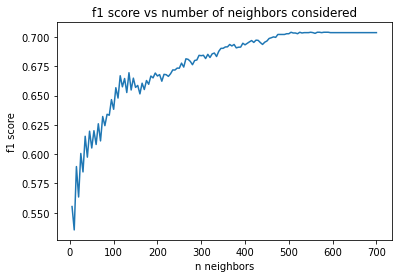

In [ ]:
import matplotlib.pyplot as plt

plt.plot( list(scores_avg.keys()), list(scores_avg.values()))
plt.xlabel('n neighbors')
plt.ylabel('f1 score')
plt.title('f1 score vs number of neighbors considered')
plt.show()

In [ ]:
knn_model_accuracy

0.5428571428571428

In [ ]:
knn_model_confusion_matrix

array([[ 33,  90],
       [ 38, 119]])

svm_model = []
mean_error = []
std_error = []
Ci_range = [0.001, 1.0, 100.0]

for index, Ci in enumerate(Ci_range):    
    svm_model.append( LinearSVC(C=Ci, max_iter=10000) )
    scores = cross_val_score(svm_model[index], Xtrain, ytrain, cv=5, scoring='f1')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())    
plt.errorbar(Ci_range, mean-error, yerr=std_error, linewidth=3)
plt.xlabel('Ci')
plt.ylabel('F1 Score')
plt.show()

In [ ]:
FIXED_C = 1

model = LinearSVC(C=FIXED_C, max_iter=10000)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xtest)
print(classification_report(ytest,ypred))
print(confusion_matrix(ytest,ypred))